In [ ]:
  !pip install scikit-plot

In [ ]:
#importing libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,confusion_matrix,roc_curve,roc_auc_score,accuracy_score,precision_score,recall_score
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
sns.set(color_codes=True)
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, BatchNormalization,concatenate,Flatten,Embedding,Dense,Dropout,MaxPooling1D,Input,Conv1D,CuDNNLSTM,Activation,Conv2D,Bidirectional
from keras.models import Model
from keras.regularizers import l1,l2
from keras.initializers import he_normal,glorot_normal
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping
from keras.callbacks import Callback
from tensorflow.keras.optimizers import Adam
import datetime
from keras.applications import inception_v3,xception
import requests
from keras.preprocessing.image import load_img,img_to_array
from PIL import Image
from sklearn.utils import shuffle
import scikitplot as skplt
from tensorflow.keras.utils import to_categorical

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/case_study_2/input/inception_features.csv')

In [ ]:
df = data[data.dank_level==0].sample(n=946,replace=False)
data = data[data['upvote ratio']>0.0016]
data = pd.concat([data,df],ignore_index=True)
data = shuffle(data)
data = data.reset_index(drop=True)

In [ ]:
X = data[['Text','media']].astype(str)
y = data['dank_level']

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.3, random_state=42,stratify=y)

### Building Xception pretrained model for Image data

In [ ]:
xception = xception.Xception(weights='imagenet',input_shape=(299, 299, 3))

91897856/91884032 [==============================] - 0s 0us/step


In [ ]:
def image_data(df):
    ls = []
    for url in tqdm(df.media.values): 
        response = requests.get(url, stream=True)
            #opening the image
        image= np.array(Image.open(response.raw))
        image= np.resize(image,(299,299,3))
        image = image.astype('float32')
        image /= 255  
        ls.append(image)   
    return ls 

train_image = image_data(x_train)
test_image = image_data(x_test)

100%|██████████| 568/568 [01:01<00:00,  9.18it/s]


### Finding Fasttext word embeddings for Text data

In [ ]:
max_words = 10000
max_len = 225
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(x_train['Text'])
train_sequences = tok.texts_to_sequences(x_train['Text'])
train_sequences_matrix = pad_sequences(train_sequences,maxlen=max_len)
word_index = tok.word_index

test_sequences = tok.texts_to_sequences(x_test['Text'])
test_sequences_matrix = pad_sequences(test_sequences,maxlen=max_len)

print("unique words : {}".format(len(word_index)))

unique words : 5067


In [ ]:
def load_fasttext():
        print('loading word embeddings...')
        embeddings_index = {}
        f = open('/content/drive/MyDrive/wiki-news-300d-1M.vec',encoding='utf-8')
        for line in tqdm(f):
            values = line.strip().rsplit(' ')
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        f.close()
        print('found %s word vectors' % len(embeddings_index))
    
        return embeddings_index

embeddings_index=load_fasttext()

loading word embeddings...


999995it [01:07, 14754.20it/s]

found 999995 word vectors


In [ ]:
embedding_mat = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vec = embeddings_index.get(word)
    if embedding_vec is not None:
        embedding_mat[i] = embedding_vec

In [ ]:
len(np.where(~embedding_mat.any(axis=1))[0])

1459

### Building Fusion model with fasttext word embeddings lstm model and xception pretrained model

In [ ]:
tf.keras.backend.clear_session()
input_text = Input(name='input_text',shape=[train_sequences_matrix.shape[1]])
layer = Embedding(len(word_index) + 1,300,weights=[embedding_mat],input_length=max_len,trainable=False)(input_text)
layer = LSTM(64,return_sequences=True)(layer)
flatten_text = Flatten()(layer)

input_image = Input(name='input_image',shape=(299,299,3))
layer = Conv2D(filters=64, kernel_size=3, strides=(4, 4), activation='relu')(input_image)
layer= Conv2D(filters=64, kernel_size=3, strides=(5, 5), activation='relu')(layer)
flatten_image = Flatten()(layer)

concat = concatenate([flatten_text,flatten_image])

dense = Dense(128,activation='relu',kernel_initializer='he_normal')(concat)
dropout = Dropout(0.3)(dense)
dense = Dense(64,activation='relu',kernel_initializer='he_normal')(dropout)
batch = BatchNormalization()(dense)
dropout = Dropout(0.2)(batch)
dense = Dense(32,activation='relu',kernel_initializer='he_normal')(dropout)
output = Dense(1,activation='sigmoid')(dense)
fusion_model = Model(inputs=[input_text,input_image],outputs=output) 

In [ ]:
fusion_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_text (InputLayer)         [(None, 225)]        0                                            
__________________________________________________________________________________________________
input_image (InputLayer)        [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 225, 300)     1520400     input_text[0][0]                 
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 75, 75, 64)   1792        input_image[0][0]                
______________________________________________________________________________________________

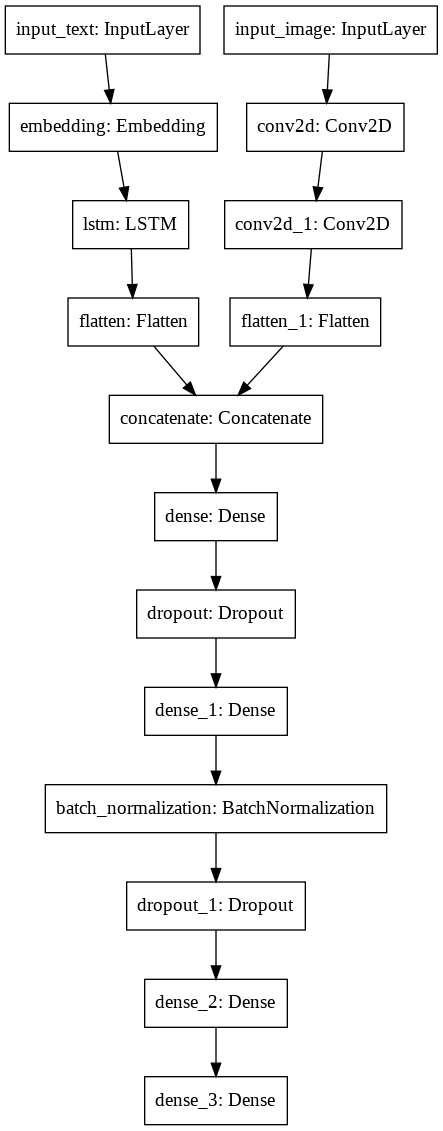

In [ ]:
plot_model(fusion_model)

In [ ]:
log_dir="/content/"  + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)
earlystop = EarlyStopping(patience=5)
checkpoint = ModelCheckpoint('weights.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
fusion_model.compile(optimizer=Adam(learning_rate=0.0006,decay = 1e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = fusion_model.fit([train_sequences_matrix,np.array(train_image,np.float32)],y_train,validation_split=0.2,epochs=20,batch_size=128,callbacks=[earlystop,checkpoint,tensorboard_callback],verbose=1)

Epoch 1/20
9/9 [==============================] - 4s 217ms/step - loss: 0.8864 - accuracy: 0.5080 - val_loss: 0.7670 - val_accuracy: 0.4528

Epoch 00001: val_loss improved from inf to 0.76699, saving model to weights.hdf5
Epoch 2/20
9/9 [==============================] - 1s 73ms/step - loss: 0.8507 - accuracy: 0.5203 - val_loss: 0.8256 - val_accuracy: 0.4528

Epoch 00002: val_loss did not improve from 0.76699
Epoch 3/20
9/9 [==============================] - 1s 71ms/step - loss: 0.8011 - accuracy: 0.5279 - val_loss: 0.7250 - val_accuracy: 0.4415

Epoch 00003: val_loss improved from 0.76699 to 0.72503, saving model to weights.hdf5
Epoch 4/20
9/9 [==============================] - 1s 74ms/step - loss: 0.7735 - accuracy: 0.5279 - val_loss: 0.6984 - val_accuracy: 0.4528

Epoch 00004: val_loss improved from 0.72503 to 0.69838, saving model to weights.hdf5
Epoch 5/20
9/9 [==============================] - 1s 70ms/step - loss: 0.7469 - accuracy: 0.5477 - val_loss: 0.6928 - val_accuracy: 0.547

In [ ]:
predictions = fusion_model.predict([test_sequences_matrix,np.array(test_image,np.float32)])

In [ ]:
predict = np.array([])
for proba in predictions:
    if proba>=0.5:
        predict = np.append(predict,np.array([1]),axis=0)
    else:
        predict = np.append(predict,np.array([0]),axis=0)

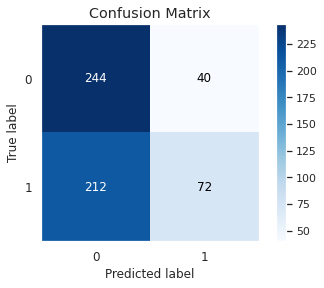

In [ ]:
matrix = skplt.metrics.plot_confusion_matrix(y_test,predict,labels=[0,1])

In [ ]:
print("Accuracy:",accuracy_score(y_test, predict))
print("Precision: ",precision_score(y_test,predict,average='macro'))
print("Recall: ",recall_score(y_test, predict,average='macro')) 
print("F-1 Score: ",f1_score(y_test, predict,average='macro'))

Accuracy: 0.5563380281690141
Precision:  0.5889724310776943
Recall:  0.556338028169014
F-1 Score:  0.5115479115479116


AUC= 0.5696166435231105


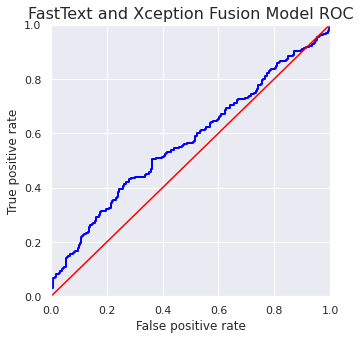

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, predictions, pos_label=1, sample_weight=None)
auc = roc_auc_score(y_test, predictions, sample_weight=None)
print("AUC=", auc)

# plot ROC curves 
plt.figure(figsize=(5,5))
plt.plot(fpr,tpr,linewidth=2.0,color='blue')
plt.plot([0,1],[0,1],color='red')
plt.xlabel('False positive rate',fontsize=12) 
plt.ylabel('True positive rate',fontsize=12)
plt.xlim([0,1]); plt.ylim([0,1])
plt.title('FastText and Xception Fusion Model ROC', fontsize=16)
plt.show()

### Visualizing Fusion Model Performance

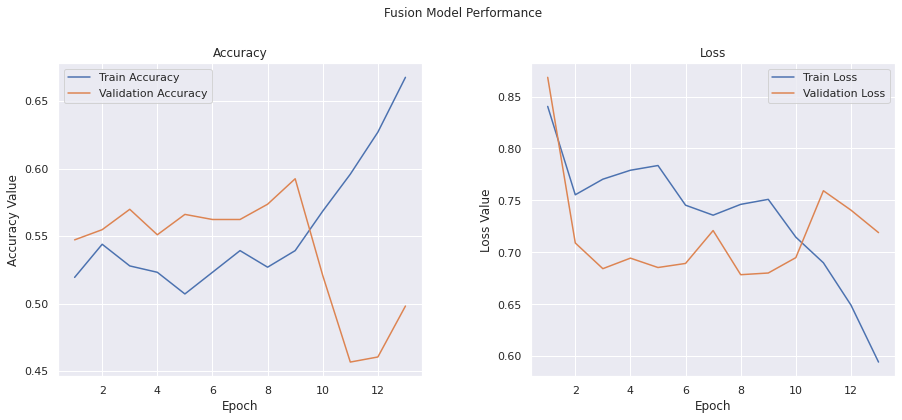

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
t = f.suptitle('Fusion Model Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

iterations = len(history.history['accuracy'])
epoch_list = list(range(1,iterations+1))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
#ax1.set_xticks(np.arange(0, 49, 10))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
#ax2.set_xticks(np.arange(0, 49, 10))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")